In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'


## Exclusions and Outliers
-- 3 subject sub-5f706a963b6ac2627a4bb3b5 & sub-611c31c77df20ecc6881cc44 reported 0 variance distributions

In [2]:
sub_df=[]
subs=os.listdir('../bids')
for sub in subs:
    #print(sub)
    if sub not in['subjects.tsv','sub-5f706a963b6ac2627a4bb3b5','sub-611c31c77df20ecc6881cc44',
                 'sub-5d8aa95dd06260000179442b']:#reported 0 variance distributions
        mem=pd.read_csv('../bids/%s/%s_mem-report.tsv'%(sub,sub),sep='\t')
        mem.percent=mem.percent.astype(int)
        mem['value']=mem['value'].astype(int)
        mem.loc[mem['value'] < 0, 'value'] = 0
        
        mem=pd.DataFrame(mem.values.repeat(mem.value, axis=0), columns=mem.columns)
        mem.percent=mem.percent.astype(int)
        mem['order']=mem['order'].astype(int)
        mem['value']=mem['value'].astype(int)
        mem=mem[['dist','percent','value','order']]
        O_df=mem.groupby('dist').mean().reset_index()
        order_var=O_df[O_df['dist']=='wide']['order'].values-O_df[O_df['dist']=='narrow']['order'].values
        if len(mem.groupby('dist').mean())>2:
            mem_df=pd.DataFrame()
            mem_df['dist']=['narrow','skew','wide']
            mem_df['narrow_first']=order_var[0]
            mem_df['means']=mem.groupby('dist').mean()['percent'].values
            mem_df['stds']=mem.groupby('dist').std()['percent'].values
            mem_df['skew']=mem.groupby('dist').skew()['percent'].values
            mem_df['sub']=(sub)
            sub_df.append(mem_df)
        else:
            #print(sub)
            pass
sub_df=pd.concat(sub_df)
sub_df=sub_df.reset_index()



In [3]:
import statsmodels.api as sm
row=[]
exclude=[]
for sub in sub_df['sub'].unique():
    df=pd.read_csv('../bids/%s/%s_task-learn_run-1_events.tsv'%(sub,sub),
                   sep='\t')
    df['choose_risk']=df['choice']=='risk'
    if any(df[df['choose_risk']==False]['per']>.99):
        exclude.append(sub)
    elif any(df[df['choose_risk']==True]['per']<0.01):
        exclude.append(sub)

print("Out of %s participants an additional %s were excluded do to choice checks"%(len(
    sub_df['sub'].unique()),len(exclude)))
print("This leaves us with a total of %s"%(len(
    sub_df['sub'].unique())-len(exclude)))
sub_df=sub_df[~sub_df['sub'].isin(exclude)]

Out of 295 participants an additional 46 were excluded do to choice checks
This leaves us with a total of 249


## Hypothesis 2a:
- Participants will be slower to change their decisions in response to feedback for ambiguous stimuli associated with a lower variance in the distribution of probability.
- H2a.) Choice ~ Probability * Distribution [‘narrow’, ‘wide’] * Feedback+ (1|sub) 

In [4]:
RL_df=[]
for sub in sub_df['sub'].unique():
    mem=pd.read_csv('../bids/%s/%s_mem-report.tsv'%(sub,sub),sep='\t')
    RL=pd.read_csv('../bids/%s/%s_task-learn_run-1_events.tsv'%(sub,sub),sep='\t')
    RL['sub']=sub
    RL['order']=sub_df[sub_df['sub']==sub]['narrow_first'].values[0]
    RL.loc[ RL["color"] == "red", "dist"] = mem[mem['Lot_color']=='R']['dist'].values[0]
    RL.loc[ RL["color"] == "green", "dist"] = mem[mem['Lot_color']=='G']['dist'].values[0]
    RL.loc[ RL["color"] == "blue", "dist"] = mem[mem['Lot_color']=='B']['dist'].values[0]
    RL_df.append(RL)
RL_df=pd.concat(RL_df)
print("no NA values for choice ",RL_df['choice'].unique())
RL_df['choose_risk']=RL_df['choice']=='risk'
print("no NA values for RL_feedback ",RL_df['RL_feedback'].unique())
RL_df['full_A']=RL_df['Amb']=='[0,1]'
print("no NA values for dist ",RL_df['dist'].unique())
RL_df['wide_dist']=RL_df['dist']=='wide'
RL_df['dist_Feed']=0
RL_df.loc[ (RL_df["dist"] == "wide")&(RL_df["RL_feedback"] == "win"),
       "dist_Feed"] = 1
RL_df.loc[ (RL_df["dist"] == "wide")&(RL_df["RL_feedback"] == "lose"),
       "dist_Feed"] = -1
RL_df.loc[ (RL_df["dist"] == "narrow")&(RL_df["RL_feedback"] == "win"),
       "dist_Feed"] = .5
RL_df.loc[ (RL_df["dist"] == "narrow")&(RL_df["RL_feedback"] == "lose"),
       "dist_Feed"] = -.5
print("",RL_df['dist_Feed'].unique())


RL_df.head()


no NA values for choice  ['risk' 'Amb']
no NA values for RL_feedback  ['lose' 'win']
no NA values for dist  ['wide' 'skew' 'narrow']
 [-1.   0.  -0.5  1.   0.5]


,Blocktype,tnum,rt,color,per,Amb,RL_feedback,choice,dist,side,response,sub,order,choose_risk,full_A,wide_dist,dist_Feed
0,Learning,1.0,1128.0,blue,0.50,"[0,1]",lose,risk,wide,right,j,sub-5858b2ca83a02d0001e38fd2,-1.0,True,True,True,-1.0
1,Learning,2.0,1603.0,blue,0.39,"[0,1]",lose,Amb,wide,left,j,sub-5858b2ca83a02d0001e38fd2,-1.0,False,True,True,-1.0
2,Learning,3.0,1284.0,blue,0.45,"[0,1]",lose,risk,wide,left,f,sub-5858b2ca83a02d0001e38fd2,-1.0,True,True,True,-1.0
3,Learning,4.0,1540.0,blue,0.40,"[0,1]",lose,risk,wide,right,j,sub-5858b2ca83a02d0001e38fd2,-1.0,True,True,True,-1.0
4,Learning,5.0,572.0,blue,0.35,"[0,1]",lose,Amb,wide,right,f,sub-5858b2ca83a02d0001e38fd2,-1.0,False,True,True,-1.0


In [5]:
from pymer4.models import Lmer
model_df=RL_df[RL_df['dist'].isin(['wide','narrow'])]
print("",model_df['dist_Feed'].unique())


#model = Lmer("choose_risk  ~ per*dist*RL_feedback  + (1|sub)",
#             data=model_df, family = 'binomial')
model = Lmer("choose_risk  ~ per*dist_Feed + (1|sub)",
             data=model_df, family = 'binomial')
display(model.fit())
#display(model.fit(factors={"dist_Feed": {"Wide_lose": 1, "narrow_lose": -0.5, "narrow_win": 0.5, "Wide_win": 1}}))


 [-1.  -0.5  1.   0.5]
Formula: choose_risk~per*dist_Feed+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 14599	 Groups: {'sub': 245.0}

Log-likelihood: -9191.730 	 AIC: 18393.460

Random effects:

            Name    Var    Std
sub  (Intercept)  1.031  1.015

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-4.638,-4.918,-4.358,0.143,0.010,0.007,0.013,0.010,0.007,0.013,-32.476,0.000,***
per,9.199,8.688,9.711,0.261,9889.027,5929.536,16492.495,1.000,1.000,1.000,35.251,0.000,***
dist_Feed,-0.079,-0.264,0.106,0.094,0.924,0.768,1.112,0.480,0.434,0.527,-0.836,0.403,
per:dist_Feed,-0.502,-0.874,-0.129,0.190,0.606,0.417,0.879,0.377,0.294,0.468,-2.638,0.008,**


from scipy.stats import chisquare
model_df['distwide']=model_df['dist']=='wide'
model_df['RL_feedbackwin']=model_df['RL_feedback']=='win'
model_df['per:distwide']=model_df['per']*model_df['distwide']
model_df['per:RL_feedbackwin']=model_df['per']*model_df['RL_feedbackwin']
model_df['distwide:RL_feedbackwin']=model_df['distwide']*model_df['RL_feedbackwin']
model_df['per:distwide:RL_feedbackwin']=model_df['per']*model_df['distwide']*model_df['RL_feedbackwin']
y_pred=(model.predict(model_df)>0.5)
y_true=model_df['choose_risk'].values
display(chisquare([np.sum([a == p for a,p in zip(y_pred,y_true)]),
           np.sum([a != p for a,p in zip(y_pred,y_true)])]))
np.mean(y_pred==y_true)

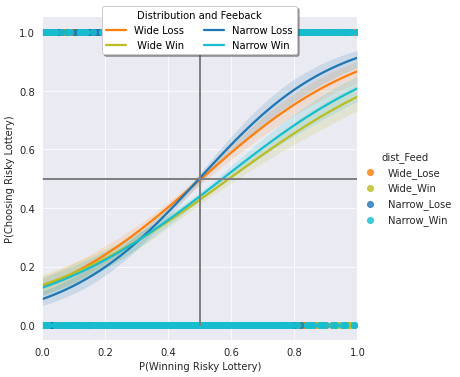

In [19]:
RL_df.loc[ (RL_df["dist"] == "wide")&(RL_df["RL_feedback"] == "win"),
       "dist_Feed"] = 'Wide_Win'
RL_df.loc[ (RL_df["dist"] == "wide")&(RL_df["RL_feedback"] == "lose"),
       "dist_Feed"] = 'Wide_Lose'
RL_df.loc[ (RL_df["dist"] == "narrow")&(RL_df["RL_feedback"] == "win"),
       "dist_Feed"] = 'Narrow_Win'
RL_df.loc[ (RL_df["dist"] == "narrow")&(RL_df["RL_feedback"] == "lose"),
       "dist_Feed"] = 'Narrow_Lose'
plt_df=RL_df[RL_df['dist'].isin(['wide','narrow'])]

pal = [plt.cm.tab20(2),plt.cm.tab10(8),plt.cm.tab20(0),plt.cm.tab10(9)]
with sns.axes_style("darkgrid"):
    ax=sns.lmplot(x='per',y='choose_risk',hue='dist_Feed',data=plt_df,logistic=True,
                  palette=pal,hue_order=['Wide_Lose','Wide_Win','Narrow_Lose','Narrow_Win'])
plt.legend(labels = ['Wide Loss', ' Wide Win', 'Narrow Loss', 'Narrow Win'], title = "Distribution and Feeback",
           loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=2, fancybox=True, shadow=True)
ax.set_xlabels('P(Winning Risky Lottery)')
ax.set_ylabels('P(Choosing Risky Lottery)')
plt.plot([0,1], [0.5,0.5], linewidth=2,color='grey')
plt.plot([.50,.50], [0,1], linewidth=2,color='grey')


# Hypothesis 2b
-Changes in decisions will be related to an interaction of the estimated mean and variance of the distribution of probabilities for an optimal Bayesian learner given each participant’s reported belief about the distribution of probabilities as a prior
- Choice ~ Probability + Mean(posterior) * Var (posterior) + (1|sub) 

## Calculate Posterior

In [7]:
from statsmodels.stats.weightstats import DescrStatsW
subs=os.listdir('../bids')

full_df=[]
for sub in subs:
    #print(sub)
    if sub not in['subjects.tsv']:#reported 0 variance distributions
        mem=pd.read_csv('../bids/%s/%s_mem-report.tsv'%(sub,sub),sep='\t')
        if len(mem.groupby('dist').mean())<2:
            print("didn't answer for all dists",sub)
        else:
            vals=[]
            for dist in ['narrow','wide','skew']:
                vals.append(len(mem[(mem['dist']=='wide')&(mem['value']>0)]))
            if any([val<2 for val in vals]):
                print("non zero std ",sub)
            else:
                mem.percent=mem.percent.astype(int)

                mem['value']=mem['value'].astype(int)
                mem.loc[mem['value'] < 0, 'value'] = 0
                tmp=[]

                for dist in ['narrow','wide','skew']:
                    wide_d=mem[mem['dist']==dist].copy()
                    wide_d['degree']=np.divide(wide_d['value'],wide_d['value'].sum())
                    wide_d['posterior_win']=np.divide(np.multiply(wide_d['percent'],wide_d['degree']),
                                                      np.sum(wide_d['degree']*wide_d['percent']))

                    wide_d['posterior_win']
                    wide_d['posterior_lose']=np.divide(np.multiply(100-wide_d['percent'],wide_d['degree']),
                                                       np.sum(wide_d['degree']*(100-wide_d['percent'])))
                    weighted_stats = DescrStatsW(wide_d['percent'], weights=wide_d['degree'], ddof=0)
                    wide_d['Mean_degree']=weighted_stats.mean
                    wide_d['STD_degree']=weighted_stats.std

                    weighted_stats = DescrStatsW(wide_d['percent'], weights=wide_d['posterior_win'], ddof=0)
                    wide_d['Mean_posterior_win']=weighted_stats.mean
                    wide_d['STD_posterior_win']=weighted_stats.std

                    weighted_stats = DescrStatsW(wide_d['percent'], weights=wide_d['posterior_lose'], ddof=0)
                    wide_d['Mean_posterior_lose']=weighted_stats.mean
                    wide_d['STD_posterior_lose']=weighted_stats.std

                    tmp.append(wide_d[['dist','Mean_degree','STD_degree',
                                      'Mean_posterior_win','STD_posterior_win',
                                      'Mean_posterior_lose','STD_posterior_lose']])
                df=pd.concat(tmp)
                df=df.groupby(by='dist').mean().reset_index()
                df['sub']=sub
                full_df.append(df)

full_df=pd.concat(full_df)
sub_df=sub_df.merge(full_df,on=['sub','dist'])

non zero std  sub-5c92870723bd7e001870138e
non zero std  sub-64270a5159f257ca7fb39155
non zero std  sub-5cb34fdb9a26a300017302d8
non zero std  sub-5fa315662ca5b25d05ae8236
non zero std  sub-6428f7ac297e312f7262d93b
non zero std  sub-611c31c77df20ecc6881cc44
non zero std  sub-56c8915edfea6c000cb29c98
non zero std  sub-62897d2024f826ea90b7efa1
non zero std  sub-5dd3eb4bc0823f3d043b96fb
non zero std  sub-62ff26509176c97c9ceebc2b
non zero std  sub-5d8aa95dd06260000179442b
non zero std  sub-63782709326973c77adc3db8
non zero std  sub-5ec97fd040ce7448f367784b
non zero std  sub-5c8198fcf29fd90001a2b9c9
non zero std  sub-63f2e107c4d0bc684b99d2c6
non zero std  sub-5bdc8d12b2fff7000189b6f8
non zero std  sub-5f706a963b6ac2627a4bb3b5
non zero std  sub-63d4d6434407b2b392e65863
non zero std  sub-637d4793730be3ac44f5a4a5


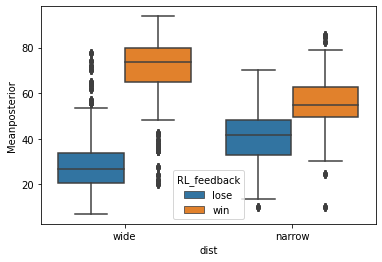

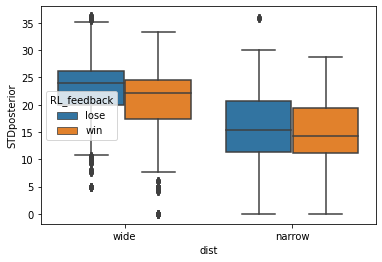

In [8]:
from pymer4.models import Lmer
model_df=pd.merge(RL_df,sub_df,on=['sub','dist'])
model_df=model_df[model_df['dist'].isin(['wide','narrow'])]
model_df['Meanposterior']=0
model_df['STDposterior']=0

model_df.loc[model_df['RL_feedback']=='win', 'Meanposterior'] = model_df['Mean_posterior_win']
model_df.loc[model_df['RL_feedback']=='lose', 'Meanposterior'] = model_df['Mean_posterior_lose']
model_df.loc[model_df['RL_feedback']=='win', 'STDposterior'] = model_df['STD_posterior_win']
model_df.loc[model_df['RL_feedback']=='lose', 'STDposterior'] = model_df['STD_posterior_lose']
sns.boxplot(data=model_df,y='Meanposterior',x='dist',hue='RL_feedback')
plt.show()
sns.boxplot(data=model_df,y='STDposterior',x='dist',hue='RL_feedback')
plt.show()

In [9]:
print("Making sure there are no NA values")
print(" Percents; %s"%model_df['per'].unique())
print(" Mean Post; %s"%any(model_df['Meanposterior'].isna()))
print(" STD Post; %s"%any(model_df['STDposterior'].isna()))

Making sure there are no NA values
 Percents; [0.5  0.39 0.45 0.4  0.35 0.38 0.43 0.46 0.42 0.41 0.36 0.61 0.55 0.57
 0.58 0.56 0.54 0.51 0.49 0.37 0.34 0.32 0.3  0.59 0.72 0.66 0.73 1.
 0.85 0.63 0.31 0.44 0.65 0.47 0.52 0.53 0.21 0.28 0.29 0.26 0.27 0.48
 0.23 0.12 0.18 0.33 0.22 0.7  0.68 0.6  0.62 0.64 0.67 0.75 0.76 0.25
 0.8  0.19 0.24 0.74 0.78 0.69 0.71 0.77 0.79 0.97 0.81 0.2  0.   0.13
 0.14 0.16 0.96 0.08 0.1  0.82 0.02 0.83 0.94 0.87 0.86 0.15 0.95 0.84
 0.98 0.88 0.92 0.89 0.93 0.17 0.11 0.07 0.09 0.01 0.03 0.9  0.91 0.04
 0.06 0.05 0.99]
 Mean Post; False
 STD Post; False


In [10]:
print("",model_df['dist_Feed'].unique())
model_df=model_df[model_df['dist'].isin(['narrow','wide'])]



model = Lmer("choose_risk  ~ per + Meanposterior*STDposterior + (1+per|sub)",
             data=model_df,  family = 'binomial')
display(model.fit(robust="hcl"))

 ['Wide_Lose' 'Wide_Win' 'Narrow_Lose' 'Narrow_Win']
[1] "Model failed to converge with max|grad| = 0.132877 (tol = 0.002, component 1)"
[2] " \n"                                                                          

[1] "Model is nearly unidentifiable: very large eigenvalue\n - Rescale variables?"
[2] " \n"                                                                         

[1] "Model is nearly unidentifiable: large eigenvalue ratio\n - Rescale variables?"
[2] " \n"                                                                          

Formula: choose_risk~per+Meanposterior*STDposterior+(1+per|sub)

Family: binomial	 Inference: parametric

Number of observations: 14179	 Groups: {'sub': 238.0}

Log-likelihood: -8284.734 	 AIC: 16585.467

Random effects:

            Name      Var     Std
sub  (Intercept)  144.264  12.011
sub          per  576.524  24.011

             IV1  IV2  Corr
sub  (Intercept)  per -0.99

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-11.648,-13.423,-9.872,0.906,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-12.857,0.000,***
per,25.416,21.970,28.861,1.758,1.091037e+11,3.478760e+09,3.421798e+12,1.000,1.000,1.000,14.457,0.000,***
Meanposterior,-0.019,-0.029,-0.010,0.005,9.810000e-01,9.710000e-01,9.900000e-01,0.495,0.493,0.498,-3.954,0.000,***
STDposterior,-0.004,-0.026,0.017,0.011,9.960000e-01,9.750000e-01,1.017000e+00,0.499,0.494,0.504,-0.401,0.688,
Meanposterior:STDposterior,0.000,-0.000,0.001,0.000,1.000000e+00,1.000000e+00,1.001000e+00,0.500,0.500,0.500,0.563,0.573,


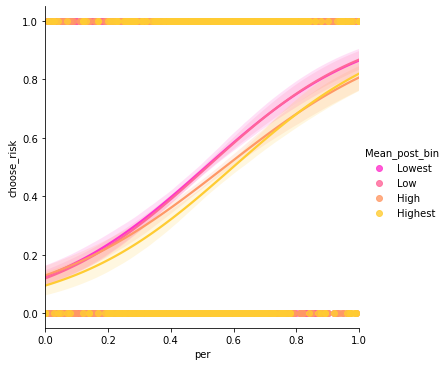

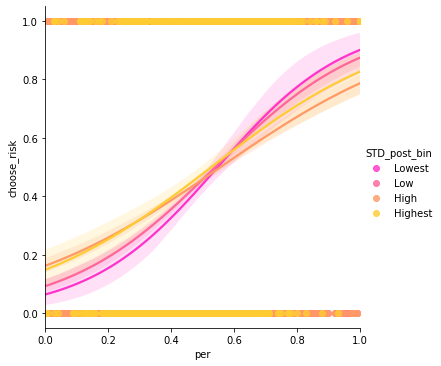

In [11]:
plt_df=model_df
plt_df['Mean_post_bin']=pd.cut(plt_df['Meanposterior'].values, bins=4,
                               labels=['Lowest','Low','High','Highest'])
plt_df['STD_post_bin']=pd.cut(plt_df['STDposterior'].values, bins=4,
                               labels=['Lowest','Low','High','Highest'])
sns.lmplot(x='per',y='choose_risk',hue='Mean_post_bin',data=plt_df,logistic=True,palette='spring')
plt.show()
sns.lmplot(x='per',y='choose_risk',hue='STD_post_bin',data=plt_df,logistic=True,palette='spring')
plt.show()